In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb 

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,precision_score,recall_score,precision_recall_fscore_support,RocCurveDisplay



Read application data, sort by IDs, check data types. We could usually make ID the index, but there are duplicate ID's as we'll see. We shall also explicitly encode some of the data types (e.g. NAME_HOUSING_TYPE as categorical type)

In [2]:
df_application_record = pd.read_csv(
    "application_record.csv",
    dtype={
        'ID':'int',
        "CODE_GENDER":"category",
        "FLAG_OWN_CAR":"category",
        "FLAG_OWN_REALTY":"category",
        "NAME_HOUSING_TYPE":"category",
        "NAME_INCOME_TYPE":"category",
        "NAME_EDUCATION_TYPE":"category",
        "NAME_FAMILY_STATUS":"category",
        "OCCUPATION_TYPE":"category",
        "FLAG_MOBIL":"category",
        "FLAG_WORK_PHONE":"category",
        "FLAG_PHONE":"category",
        "FLAG_EMAIL": "category"
        }
        ).sort_values(
            by="ID") #94 IDs are duplicated, and clearly do not correspond to same person.
df_application_record.dtypes

ID                        int64
CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
NAME_INCOME_TYPE       category
NAME_EDUCATION_TYPE    category
NAME_FAMILY_STATUS     category
NAME_HOUSING_TYPE      category
DAYS_BIRTH                int64
DAYS_EMPLOYED             int64
FLAG_MOBIL             category
FLAG_WORK_PHONE        category
FLAG_PHONE             category
FLAG_EMAIL             category
OCCUPATION_TYPE        category
CNT_FAM_MEMBERS         float64
dtype: object

94 duplicated IDs, remove them

In [3]:
df_application_record[df_application_record.ID.duplicated(keep=False)]


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426714,7836711,M,Y,N,2,315000.0,State servant,Higher education,Married,House / apartment,-11649,-1517,1,1,1,0,Managers,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
423702,7838075,F,Y,Y,0,315000.0,Commercial associate,Higher education,Single / not married,House / apartment,-10698,-1659,1,0,0,1,NaN,1.0


In [4]:
df_application_record = df_application_record[~df_application_record.ID.duplicated(keep=False)].copy()
df_application_record.set_index("ID",inplace=True)
df_application_record

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999660,F,N,N,0,90000.0,State servant,Higher education,Single / not married,House / apartment,-13432,-5446,1,0,0,0,Core staff,1.0
7999696,F,N,Y,2,135000.0,State servant,Secondary / secondary special,Married,House / apartment,-12576,-4382,1,0,0,0,Medicine staff,4.0
7999738,M,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-9970,-119,1,0,0,0,NaN,2.0


Create column for all types of unmarried people

In [5]:
print(df_application_record.groupby("NAME_FAMILY_STATUS",observed=False).size())
df_application_record["UNMARRIED"] = (df_application_record["NAME_FAMILY_STATUS"].isin(["Separated","Single / not married","Widow"])

)
df_application_record.groupby("UNMARRIED",observed=False).size()

NAME_FAMILY_STATUS
Civil marriage           36521
Married                 299768
Separated                27249
Single / not married     55255
Widow                    19670
dtype: int64


UNMARRIED
False    336289
True     102174
dtype: int64

In [6]:
df_application_record

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,UNMARRIED
ID,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,False
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,False
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,False
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,True
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999660,F,N,N,0,90000.0,State servant,Higher education,Single / not married,House / apartment,-13432,-5446,1,0,0,0,Core staff,1.0,True
7999696,F,N,Y,2,135000.0,State servant,Secondary / secondary special,Married,House / apartment,-12576,-4382,1,0,0,0,Medicine staff,4.0,False
7999738,M,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-9970,-119,1,0,0,0,NaN,2.0,False


Note that CNT_FAM_MEMBERS IS BETTER ENCODED AS INT. We could also encode it as categorical due to small set of values, but keep them as numerical due to the fact that the numbers here represent real quantities (i.e. a person who has 4 children has twice as many as a person who has 2).

In [6]:
print(set(df_application_record["CNT_FAM_MEMBERS"]))
print(set(df_application_record["CNT_CHILDREN"]))
df_application_record["CNT_FAM_MEMBERS"]=df_application_record["CNT_FAM_MEMBERS"].astype(int)

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 14.0, 15.0, 20.0}
{0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 19}


As you can see, there are some applicants with an anomalous number of children. To prevent using features with really low occurence, im going to winsorize this.

In [7]:
df_application_record.groupby(["CNT_CHILDREN"]).size()

CNT_CHILDREN
0     304007
1      88509
2      39873
3       5429
4        486
5        133
6          4
7          9
9          5
12         4
14         3
19         1
dtype: int64

<Axes: xlabel='CNT_CHILDREN'>

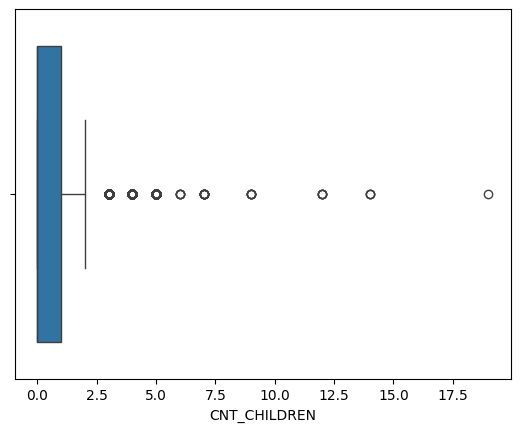

In [8]:
sns.boxplot(df_application_record,x="CNT_CHILDREN")

In [9]:
df_application_record["CNT_CHILDREN"] = np.where(df_application_record["CNT_CHILDREN"]>6,6,df_application_record["CNT_CHILDREN"])
df_application_record["has_children"] = df_application_record["CNT_CHILDREN"]>0

In [11]:
df_application_record.describe(include="category")

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE
count,438463,438463,438463,438463,438463,438463,438463,438463,438463,438463,438463,304286
unique,2,2,2,5,5,5,6,1,2,2,2,18
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Laborers
freq,294378,275396,304009,226059,301756,299768,393748,438463,348083,312290,391023,78225


OCCUPATION_TYPE has a lot of NA's, We shouldn't discard the NA's since it is a significant proportion of the population. it is also the ONLY column with NAs. Instead we will create a new category and assign NA's to that category.

In [11]:
df_application_record.isnull().sum()

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134177
CNT_FAM_MEMBERS             0
UNMARRIED                   0
has_children                0
dtype: int64

In [12]:
set(df_application_record["OCCUPATION_TYPE"])

{'Accountants',
 'Cleaning staff',
 'Cooking staff',
 'Core staff',
 'Drivers',
 'HR staff',
 'High skill tech staff',
 'IT staff',
 'Laborers',
 'Low-skill Laborers',
 'Managers',
 'Medicine staff',
 'Private service staff',
 'Realty agents',
 'Sales staff',
 'Secretaries',
 'Security staff',
 'Waiters/barmen staff',
 nan}

In [13]:
df_application_record["OCCUPATION_TYPE"] = df_application_record[
    "OCCUPATION_TYPE"
    ].cat.add_categories("Not Listed").fillna("Not Listed")

Unspecified occupation and laborers are the two largest categories by far (30% and 17%), If you include the Core Staff that gives you the majority of occupations.

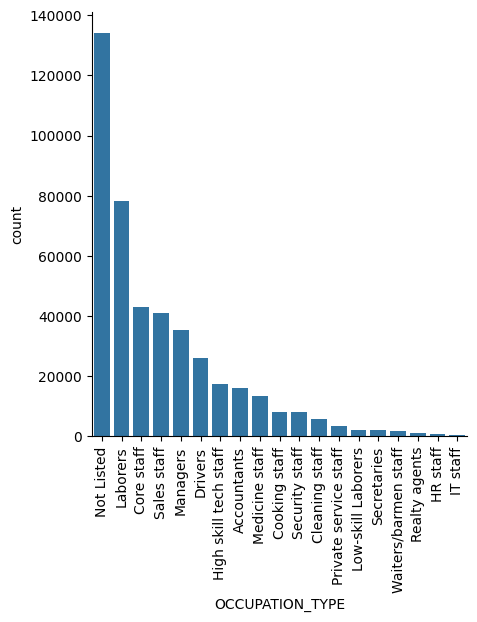

In [14]:
sns.catplot(
    df_application_record,
    x="OCCUPATION_TYPE",
    kind="count",order=df_application_record.OCCUPATION_TYPE.value_counts().index).set_xticklabels(rotation=90)

In [15]:
df_application_record.groupby(["OCCUPATION_TYPE"],observed=False).size().sort_values(ascending=False)/len(df_application_record)

OCCUPATION_TYPE
Not Listed               0.306017
Laborers                 0.178407
Core staff               0.098054
Sales staff              0.093718
Managers                 0.080912
Drivers                  0.059492
High skill tech staff    0.039417
Accountants              0.036445
Medicine staff           0.030830
Cooking staff            0.018414
Security staff           0.018230
Cleaning staff           0.013326
Private service staff    0.007880
Low-skill Laborers       0.004881
Secretaries              0.004662
Waiters/barmen staff     0.003797
Realty agents            0.002374
HR staff                 0.001765
IT staff                 0.001378
dtype: float64

In [17]:
df_application_record.groupby(["NAME_INCOME_TYPE"],observed=False).size().sort_values(ascending=False)/len(df_application_record)

NAME_INCOME_TYPE
Working                 0.515571
Commercial associate    0.229725
Pensioner               0.172142
State servant           0.082522
Student                 0.000039
dtype: float64

Create feature of num family members that aren't children. Note that there are some negative values there. Maybe these should be removed?

In [18]:
df_application_record["DIFF_FAM_CHILD"] = df_application_record["CNT_FAM_MEMBERS"]-df_application_record["CNT_CHILDREN"]
set(df_application_record["DIFF_FAM_CHILD"] )

{-2, -1, 0, 1, 2, 3, 5, 8, 9, 14}

Read file containing credit record of some customers.

In [19]:
df_credit_record = pd.read_csv("credit_record.csv")
df_credit_record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


df_credit_record is a history of the credit of the customers. In this case, we will have duplicate IDs, but corresponding to different months. This is to be expected and therefore should not be deduplicated.

In [20]:
print(len(df_credit_record))
len(df_credit_record) == len(df_credit_record.drop_duplicates(subset=["ID","MONTHS_BALANCE"]))

1048575


True

Note that the number of customers here is much less than the ones in the application_record csv, so when we do the inner merge for the model a lot of entries in the application_record will be missing. That is ok for training the model, we might want to apply  predictions to the entries in application_record without a history, in order to do this the predictor variables would need to be a function only of info in application_record.

In [21]:
len(set(df_credit_record["ID"]))

45985

Note that C,0 and X are the vast majority of the cases, however 1-5 are the labels corresponding "worrisome" behaviour (with 5 being the category corresponding to bad loans).

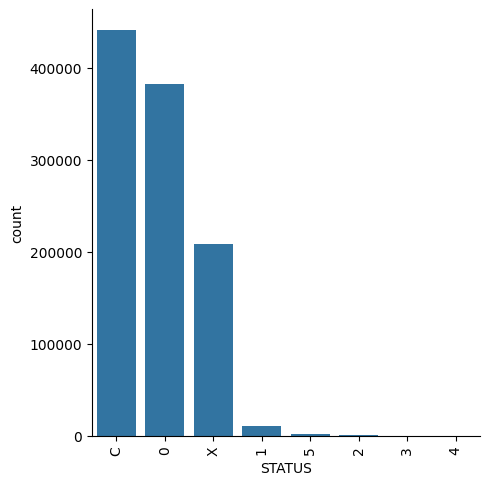

In [22]:
sns.catplot(
    df_credit_record,
    x="STATUS",
    kind="count",order=df_credit_record.STATUS.value_counts().index).set_xticklabels(rotation=90)

In [23]:
df_credit_record.groupby(["STATUS"],observed=False).size().sort_values(ascending=False)/len(df_credit_record)

STATUS
C    0.421554
0    0.365372
X    0.199537
1    0.010576
5    0.001615
2    0.000828
3    0.000305
4    0.000213
dtype: float64

At this point, we see some design challenges. We could try to formulate the goal as predicting a vector P with the proportions observed in each class, and formulate some decision logic based around this. Note, that this would be a difficult problem due to the vector having 8 dimensions and very little examples in some categories, and not necessarily useful towards the end-goal of determining the best customers.
A customer who only has X and C is a good customer. 0 is a category which could be interpreted as "slightly" bad, however it is not uncommon to have good customers accidentally be slightly late. 
My design choice for finding the "best" customers will be: those that have no 1-5 in their history, and where the 0's occur at most 15% of the months. I will be doing it like this in order to do binary classification, 

In [24]:
df_credit_record["acceptable_month"] = (
    (df_credit_record["STATUS"]=="C" )
    | (df_credit_record["STATUS"]=="X" )
    | (df_credit_record["STATUS"]=="0" )
)
is_customer_acceptable = df_credit_record.groupby("ID")["acceptable_month"].all()
is_customer_acceptable.sum()/len(is_customer_acceptable) #88% of customers have no Status 1-5

0.8836577144721105

In [25]:
df_credit_record["is_zero"] = df_credit_record["STATUS"]=="0"
zero_rate = df_credit_record.groupby("ID")["is_zero"].mean()
is_good_customer = is_customer_acceptable & (zero_rate<0.15)
is_good_customer.sum()/len(is_good_customer) #88% of customers have no Status 1-5


0.23699032293139066

In [26]:
df_credit_record.groupby("ID")["acceptable_month"].all()

ID
5001711    True
5001712    True
5001713    True
5001714    True
5001715    True
           ... 
5150482    True
5150483    True
5150484    True
5150485    True
5150487    True
Name: acceptable_month, Length: 45985, dtype: bool

Note that if we become more strict, and only allow C,X, the proportion of positives drops down drastically to .13

In [27]:
df_credit_record["great_month"] = (
    (df_credit_record["STATUS"]=="C" )
    | (df_credit_record["STATUS"]=="X" )
)
is_customer_great = df_credit_record.groupby("ID")["great_month"].all()
is_customer_great.sum()/len(is_customer_great)

0.12945525714907036

In [28]:
df_for_model = df_application_record.merge(
    is_good_customer.rename("is_good"),
    how="inner",left_index=True,right_index=True)

In [29]:
df_for_model.dtypes

CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
NAME_INCOME_TYPE       category
NAME_EDUCATION_TYPE    category
NAME_FAMILY_STATUS     category
NAME_HOUSING_TYPE      category
DAYS_BIRTH                int64
DAYS_EMPLOYED             int64
FLAG_MOBIL             category
FLAG_WORK_PHONE        category
FLAG_PHONE             category
FLAG_EMAIL             category
OCCUPATION_TYPE        category
CNT_FAM_MEMBERS           int64
UNMARRIED                  bool
has_children               bool
DIFF_FAM_CHILD            int64
is_good                    bool
dtype: object

Create dummy features from cat. variables

In [30]:
df_w_dummies = pd.get_dummies(df_for_model)

Estimate correlation of predicted columns with target variable

In [12]:
corr_val = df_w_dummies.corr()['is_good'] 

NameError: name 'df_w_dummies' is not defined

In [31]:
df_w_dummies

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,UNMARRIED,has_children,DIFF_FAM_CHILD,is_good,CODE_GENDER_F,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_Not Listed
ID,,,,,,,,,,,,,,,,,,,,,
5008804,0,427500.0,-12005,-4542,2,False,False,2,False,False,...,False,False,False,False,False,False,False,False,False,True
5008805,0,427500.0,-12005,-4542,2,False,False,2,False,False,...,False,False,False,False,False,False,False,False,False,True
5008806,0,112500.0,-21474,-1134,2,False,False,2,False,False,...,False,False,False,False,False,False,False,True,False,False
5008808,0,270000.0,-19110,-3051,1,True,False,1,False,True,...,False,False,False,False,False,True,False,False,False,False
5008809,0,270000.0,-19110,-3051,1,True,False,1,True,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,1,157500.0,-10808,-1739,3,False,True,2,False,True,...,False,False,False,False,False,False,False,False,False,False
5150483,1,157500.0,-10808,-1739,3,False,True,2,True,True,...,False,False,False,False,False,False,False,False,False,False
5150484,1,157500.0,-10808,-1739,3,False,True,2,False,True,...,False,False,False,False,False,False,False,False,False,False


In [32]:
Y_val = df_w_dummies["is_good"]
X_vals = df_w_dummies.drop(columns=["is_good"])
Y_val

ID
5008804    False
5008805    False
5008806    False
5008808    False
5008809     True
           ...  
5150482    False
5150483     True
5150484    False
5150485    False
5150487     True
Name: is_good, Length: 36457, dtype: bool

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_vals,Y_val, 
                                                    stratify=Y_val, test_size=0.2,
                                                    random_state = 42)

3.505638807353623
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END colsample_bytree=0.7, eta=0.3, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=3.505638807353623, seed=42, tree_method=exact;, score=0.679 total time=   5.8s
[CV 2/5] END colsample_bytree=0.7, eta=0.3, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=3.505638807353623, seed=42, tree_method=exact;, score=0.690 total time=   4.8s
[CV 3/5] END colsample_bytree=0.7, eta=0.3, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=3.505638807353623, seed=42, tree_method=exact;, score=0.690 total time=   4.8s
[CV 4/5] END colsample_bytree=0.7, eta=0.3, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=3.505638807353623, seed=42, tree_method=exact;, score=0.683 total time=   4.6s
[CV 5/5] END colsample_bytree=0.7, e

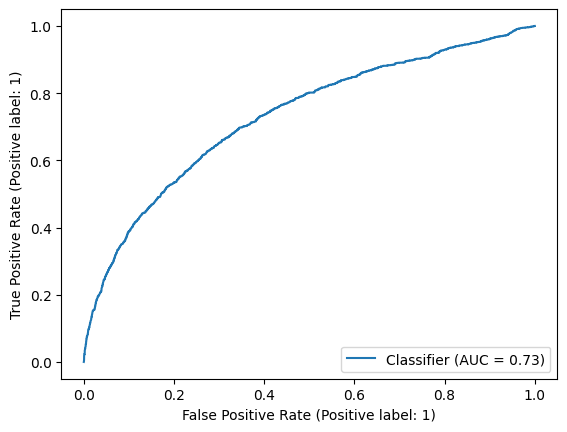

In [41]:
clf_base_xgb = xgb.XGBClassifier() 
spw = ((1-y_train).sum()/y_train.sum())
print(spw)
params = {
    "eta":[0.2,0.3,0.4],
    "learning_rate":[0.05,0.10,0.15,0.20,0.25],
    "max_depth":[7,8,9,10,11,12],
    "min_child_weight":[3,5,7,9],
    "gamma":[0.0,0.1,0.2,0.3],
    "colsample_bytree":[0.3,0.5,0.7],
    "n_estimators":[100,200],

    "tree_method":["exact"],
    "scale_pos_weight":[spw],
    "seed":[42]
}

search = RandomizedSearchCV(clf_base_xgb,param_distributions=params,n_iter=40,scoring="roc_auc",verbose=3,random_state=42)
clf = search.fit(X_train,y_train)
best_xgb = clf.best_estimator_

y_pred = best_xgb.predict(X_test)




(array([0.8720339 , 0.39424572]), array([0.72541417, 0.62669963]), array([0.79199538, 0.48400955]), array([5674, 1618]))


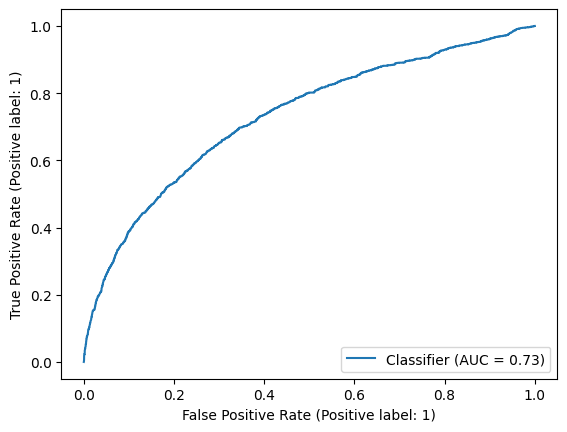

In [42]:
print(precision_recall_fscore_support(y_test,y_pred))

RocCurveDisplay.from_predictions(y_test,best_xgb.predict_proba(X_test)[:,1])

In [43]:
print(precision_score(y_test,y_pred) )
print(recall_score(y_test,y_pred) )


0.3942457231726283
0.6266996291718171


In [44]:
clf.best_params_

{'tree_method': 'exact',
 'seed': 42,
 'scale_pos_weight': 3.505638807353623,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'eta': 0.3,
 'colsample_bytree': 0.5}

In [36]:
best_xgb.get_booster().get_fscore()

{'CNT_CHILDREN': 252.0,
 'AMT_INCOME_TOTAL': 1356.0,
 'DAYS_BIRTH': 2482.0,
 'DAYS_EMPLOYED': 1772.0,
 'CNT_FAM_MEMBERS': 195.0,
 'UNMARRIED': 89.0,
 'has_children': 33.0,
 'DIFF_FAM_CHILD': 23.0,
 'CODE_GENDER_F': 199.0,
 'CODE_GENDER_M': 50.0,
 'FLAG_OWN_CAR_N': 194.0,
 'FLAG_OWN_CAR_Y': 69.0,
 'FLAG_OWN_REALTY_N': 220.0,
 'FLAG_OWN_REALTY_Y': 101.0,
 'NAME_INCOME_TYPE_Commercial associate': 141.0,
 'NAME_INCOME_TYPE_Pensioner': 23.0,
 'NAME_INCOME_TYPE_State servant': 68.0,
 'NAME_INCOME_TYPE_Working': 133.0,
 'NAME_EDUCATION_TYPE_Academic degree': 3.0,
 'NAME_EDUCATION_TYPE_Higher education': 138.0,
 'NAME_EDUCATION_TYPE_Incomplete higher': 46.0,
 'NAME_EDUCATION_TYPE_Lower secondary': 12.0,
 'NAME_EDUCATION_TYPE_Secondary / secondary special': 155.0,
 'NAME_FAMILY_STATUS_Civil marriage': 45.0,
 'NAME_FAMILY_STATUS_Married': 126.0,
 'NAME_FAMILY_STATUS_Separated': 45.0,
 'NAME_FAMILY_STATUS_Single / not married': 60.0,
 'NAME_FAMILY_STATUS_Widow': 45.0,
 'NAME_HOUSING_TYPE_Co-op ap

In [37]:
print(confusion_matrix(y_test,y_pred) )


[[4095 1579]
 [ 643  975]]


In [45]:
y_pred_proba = best_xgb.predict_proba(X_test)[:,1]

In [53]:
# adapted from https://github.com/APavlides/cap_curve/blob/master/cap_curve.py
import matplotlib.pyplot as plt

def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    

    
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    #ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    #ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve ")
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.show()

      0         1
0   1.0  0.991851
1   0.0  0.991851
2   1.0  0.990598
3   1.0  0.986189
4   0.0  0.983007
5   1.0  0.978321
6   1.0  0.977599
7   1.0  0.977599
8   1.0  0.977152
9   1.0  0.977152
10  1.0  0.977152
11  0.0  0.977152
12  1.0  0.976551
13  1.0  0.976551
14  1.0  0.976551
15  1.0  0.976551
16  1.0  0.975018
17  1.0  0.975018
18  1.0  0.975018
19  1.0  0.975018


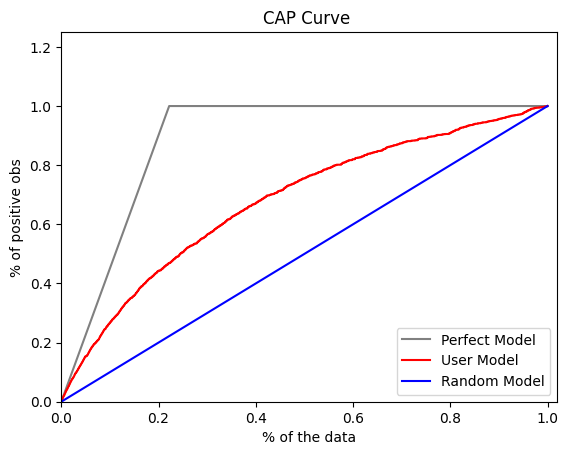

In [52]:
capcurve(y_test,y_pred_proba)